0.8634030303030308
0.8502090909090914
0.8783363636363641
0.8611848484848489
0.8548545454545459
0.8500969696969701
0.854475757575758
0.8677606060606065
0.8743151515151519
0.8850242424242429
0.8648969696969702
0.8513666666666672
0.8682727272727278
0.8654303030303034
0.8690303030303035
0.855366666666667
0.8557454545454549
0.8846242424242429
0.8582090909090914
0.8676272727272731
0.867515151515152
0.8565606060606065
0.8549878787878792
0.8540545454545458
0.8648757575757581
0.8712272727272732
0.8520121212121217
0.8754727272727277
0.8778939393939399
0.861675757575758
0.8714515151515156
0.8619424242424246
0.8823151515151519
0.8582090909090914
0.8617878787878792
0.8584545454545459
0.8688969696969702
0.8752272727272732
0.8778242424242428
0.8556121212121217
0.8750727272727278
0.8753606060606065
0.8688969696969702
0.8892909090909096
0.8824484848484853
0.8678727272727277
0.8686515151515156
0.8688969696969702
0.8576969696969701
0.8620545454545459
0.8645181818181823
0.8785818181818187
0.86232121212121

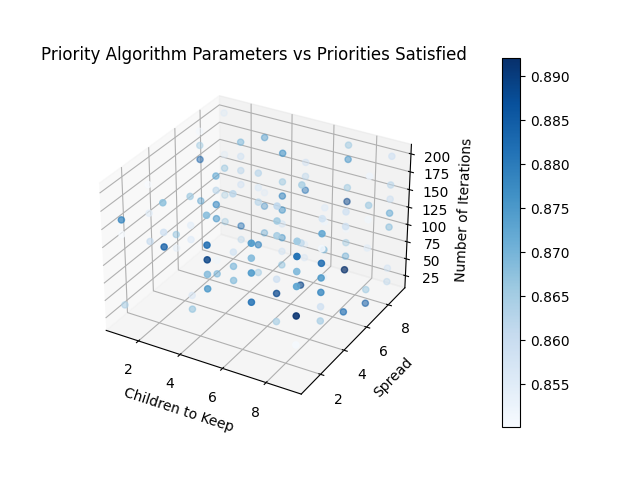

In [8]:
from typing import Dict, Tuple

import matplotlib
import typer
from matplotlib import pyplot as plt, cm

from api.ai.interfaces.algorithm_config import PriorityAlgorithmConfig
from api.models.enums import Gender, ScenarioAttribute, AlgorithmType
from benchmarking.data.simulated_data.mock_student_provider import (
    MockStudentProvider,
    MockStudentProviderSettings,
)
from benchmarking.evaluations.metrics.priority_satisfaction import PrioritySatisfaction
from benchmarking.evaluations.scenarios.diversify_gender_min_2_female import (
    DiversifyGenderMin2Female,
)
from benchmarking.runs.interfaces import Run
from benchmarking.simulation.goal_to_priority import goals_to_priorities
from benchmarking.simulation.insight import Insight
from benchmarking.simulation.simulation_set import SimulationSet, SimulationSetArtifact
from benchmarking.simulation.simulation_settings import SimulationSettings
from utils.math import change_range

%matplotlib widget

generate_graphs = True
num_trials = 10

# Bounds
MAX_KEEP_UPPER_BOUND = 10
MAX_KEEP_LOWER_BOUND = 1
MAX_KEEP_INCREMENT = 2
MAX_SPREAD_UPPER_BOUND = 10
MAX_SPREAD_LOWER_BOUND = 1
MAX_SPREAD_INCREMENT = 2
MAX_ITERATION_UPPER_BOUND = 200
MAX_ITERATION_LOWER_BOUND = 20
MAX_ITERATION_INCREMENT = 20
RATIO_OF_FEMALE_STUDENT = 0.4

"""
Goal:
- Need to create a run to generate all the data for max spread, max keep, and max iterations
- Create a graph function to plot the data in 3D and generate the heat map
- Need to rationalize bounds for each of the items in the plot (consider relationships between features)
- We will be ignoring max time as it is just an arbitrary value we impose on the algorithm to reduce computation time
"""

scenario = DiversifyGenderMin2Female(value_of_female=Gender.FEMALE.value)
class_size = 120
team_size = 5
num_teams = class_size // team_size

student_provider_settings = MockStudentProviderSettings(
    number_of_students=class_size,
    attribute_ranges={
        ScenarioAttribute.GENDER.value: [
            (Gender.MALE, 1 - RATIO_OF_FEMALE_STUDENT),
            (Gender.FEMALE, RATIO_OF_FEMALE_STUDENT),
        ],
    },
)

metrics = {
    "PrioritySatisfaction": PrioritySatisfaction(
        goals_to_priorities(scenario.goals),
        False,
    ),
}

# Use as `artifacts[max_keep][max_spread][max_iterations]`
artifacts: Dict[Tuple[int, int, int], SimulationSetArtifact] = {}

# Ranges
max_keep_range = list(
    range(
        MAX_KEEP_LOWER_BOUND,
        MAX_KEEP_UPPER_BOUND + 1,
        MAX_KEEP_INCREMENT,
    )
)
max_spread_range = list(
    range(
        MAX_SPREAD_LOWER_BOUND,
        MAX_SPREAD_UPPER_BOUND + 1,
        MAX_SPREAD_INCREMENT,
    )
)
max_iterations_range = list(
    range(
        MAX_ITERATION_LOWER_BOUND,
        MAX_ITERATION_UPPER_BOUND + 1,
        MAX_ITERATION_INCREMENT,
    )
)

for max_keep in max_keep_range:
    for max_spread in max_spread_range:
        for max_iterations in max_iterations_range:
            # print(
            #     f"max_keep: {max_keep}, max_spread: {max_spread}, max_iterations: {max_iterations}"
            # )
            artifacts[(max_keep, max_spread, max_iterations)] = SimulationSet(
                settings=SimulationSettings(
                    num_teams=num_teams,
                    scenario=scenario,
                    student_provider=MockStudentProvider(
                        student_provider_settings
                    ),
                    cache_key=f"priority_algorithm/all_parameters/diversify_gender_min_2/max_keep_{max_keep}/max_spread_{max_spread}/max_iterations_{max_iterations}",
                ),
                algorithm_set={
                    AlgorithmType.PRIORITY: [
                        PriorityAlgorithmConfig(
                            MAX_KEEP=max_keep,
                            MAX_SPREAD=max_spread,
                            MAX_ITERATE=max_iterations,
                            MAX_TIME=10000000,
                        )
                    ]
                },
            ).run(num_runs=num_trials)

if generate_graphs:
    # Process data and plot
    for metric_name, metric in metrics.items():
        # Dict with points[(x, y, z)] = color (value between 0-1 as position on color map)
        points: Dict[Tuple[int, int, int], float] = {}
        for point_location, simulation_artifact in artifacts.items():
            insight_set = Insight.get_output_set(
                artifact=simulation_artifact,
                metrics=[metric],
            )

            # Returns a dict[algorithm, value]
            value_dict = Insight.average_metric(
                insight_output_set=insight_set, metric_name=metric_name
            )

            # Get first value, assumes only one algorithm being run
            value = list(value_dict.values())[0]
            # points[point_location] = value
            if 0.85 <= value:
                points[point_location] = value
                print(value)

        # Graph data
        %matplotlib widget
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        cmap = plt.get_cmap("Blues")
        c_norm = matplotlib.colors.Normalize(vmin=min(list(points.values())), vmax=max(list(points.values())))
        scalar_map = cm.ScalarMappable(norm=c_norm, cmap=cmap)

        values = list(points.values())

        ax.scatter(
            [x for x, y, z in points.keys()],
            [y for x, y, z in points.keys()],
            [z for x, y, z in points.keys()],
            c=scalar_map.to_rgba(values),
        )

        ax.set_title("Priority Algorithm Parameters vs Priorities Satisfied")
        ax.set_xlabel("Children to Keep")
        ax.set_ylabel("Spread")
        ax.set_zlabel("Number of Iterations")

        # Plot color scale
        scalar_map.set_array(values)
        fig.colorbar(scalar_map, ax=ax, pad=0.15)
        plt.show()
